# 감정분석 기반 주가 예측 시스템 (LSTM)

이 노트북은 다음 3가지 데이터를 통합하여 주가 방향성을 예측합니다:

1. **📰 뉴스 감정분석 (FinBERT)**: 금융 뉴스의 감정 점수
2. **🐦 트위터 감정분석 (VADER)**: 소셜미디어의 실시간 감정
3. **📈 주가 데이터**: AAPL 1시간 간격 주가 정보

## 목표
- **입력**: 과거 24시간의 감정 + 주가 데이터
- **출력**: 다음 시간의 주가 방향성 (상승/유지/하락)


## 1️⃣ 라이브러리 Import 및 기본 설정

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 기본 ML 라이브러리
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("✅ 기본 라이브러리 로딩 완료!")
print(f"📊 사용 환경: pandas {pd.__version__}, numpy {np.__version__}")

# TensorFlow는 설치 문제로 인해 나중에 처리
try:
    import tensorflow as tf
    print(f"🤖 TensorFlow {tf.__version__} 사용 가능")
    TF_AVAILABLE = True
except ImportError:
    print("⚠️ TensorFlow 미설치 - 대안 모델 사용 예정")
    TF_AVAILABLE = False


✅ 기본 라이브러리 로딩 완료!
📊 사용 환경: pandas 2.2.3, numpy 1.24.4
🤖 TensorFlow 2.13.0 사용 가능


## 2️⃣ 데이터 파일 경로 설정 및 확인

In [2]:
import os

# 데이터 파일 경로 설정
stock_file = "../stock/AAPL_1hour_data_365days.csv"  # 주가 데이터
news_file = "../finnhub/AAPL_finnhub_processed_final.csv"  # 뉴스 감정분석
twitter_file = "../X_data/merged_tweets_with_sentiment.csv"  # 트위터 감정분석

# 파일 존재 여부 확인
files_info = {
    "📈 주가 데이터": stock_file,
    "📰 뉴스 감정분석": news_file, 
    "🐦 트위터 감정분석": twitter_file
}

print("📁 데이터 파일 확인:")
print("=" * 50)

all_files_exist = True
for name, path in files_info.items():
    if os.path.exists(path):
        size_mb = os.path.getsize(path) / (1024*1024)
        print(f"✅ {name}: {path} ({size_mb:.1f}MB)")
    else:
        print(f"❌ {name}: {path} (파일 없음)")
        all_files_exist = False

if all_files_exist:
    print("\n🎉 모든 데이터 파일이 준비되었습니다!")
else:
    print("\n⚠️ 일부 파일이 누락되었습니다. 경로를 확인해주세요.")


📁 데이터 파일 확인:
✅ 📈 주가 데이터: ../stock/AAPL_1hour_data_365days.csv (1.9MB)
✅ 📰 뉴스 감정분석: ../finnhub/AAPL_finnhub_processed_final.csv (3.0MB)
✅ 🐦 트위터 감정분석: ../X_data/merged_tweets_with_sentiment.csv (1.9MB)

🎉 모든 데이터 파일이 준비되었습니다!


## 3️⃣ 데이터 로딩 및 기본 탐색

In [3]:
# 1. 주가 데이터 로드
print("📈 주가 데이터 로딩...")
stock_df = pd.read_csv(stock_file)
stock_df['Datetime'] = pd.to_datetime(stock_df['Datetime'])

# 시간대 정보 확인 및 정리
print(f"🕐 시간대 정보: {stock_df['Datetime'].dt.tz}")
if stock_df['Datetime'].dt.tz is not None:
    print("  UTC 시간대 정보 제거 중...")
    stock_df['Datetime'] = stock_df['Datetime'].dt.tz_localize(None)
    print("  ✅ 시간대 정보 제거 완료")

stock_df = stock_df.sort_values('Datetime').reset_index(drop=True)

print(f"✅ 주가 데이터: {len(stock_df):,}개 행")
print(f"📅 기간: {stock_df['Datetime'].min()} ~ {stock_df['Datetime'].max()}")
print(f"📋 컬럼: {list(stock_df.columns)}")
print(f"\n주가 데이터 미리보기:")
stock_df.head()


📈 주가 데이터 로딩...
🕐 시간대 정보: UTC
  UTC 시간대 정보 제거 중...
  ✅ 시간대 정보 제거 완료
✅ 주가 데이터: 3,889개 행
📅 기간: 2024-06-17 08:00:00 ~ 2025-06-13 23:00:00
📋 컬럼: ['Datetime', 'Close', 'High', 'Low', 'Open', 'Volume', 'Returns', 'Log_Returns', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'MACD_Histogram', 'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'BB_Width', 'BB_Position', 'Volatility_10', 'Volatility_20', 'Price_Change', 'Price_Change_Pct', 'HL_Spread', 'HL_Spread_Pct', 'Hour', 'DayOfWeek', 'Month', 'Quarter', 'Is_Trading_Hours', 'Is_Market_Open', 'Is_Premarket', 'Is_Aftermarket', 'Is_Extended_Hours']

주가 데이터 미리보기:


,Datetime,Close,High,Low,Open,Volume,Returns,Log_Returns,SMA_10,SMA_20,...,HL_Spread_Pct,Hour,DayOfWeek,Month,Quarter,Is_Trading_Hours,Is_Market_Open,Is_Premarket,Is_Aftermarket,Is_Extended_Hours
0,2024-06-17 08:00:00,214.350,214.36,212.82,213.24,0,NaN,NaN,NaN,NaN,...,0.718451,8,0,6,2,0,0,1,0,1
1,2024-06-17 09:00:00,213.930,214.62,213.66,214.24,0,-0.001959,-0.001961,NaN,NaN,...,0.448745,9,0,6,2,1,1,0,0,0
2,2024-06-17 10:00:00,213.620,214.10,213.61,213.96,0,-0.001449,-0.001450,NaN,NaN,...,0.229379,10,0,6,2,1,1,0,0,0
3,2024-06-17 11:00:00,213.960,214.18,213.62,213.62,0,0.001592,0.001590,NaN,NaN,...,0.261731,11,0,6,2,1,1,0,0,0
4,2024-06-17 12:00:00,214.145,214.60,212.62,213.94,0,0.000865,0.000864,NaN,NaN,...,0.924607,12,0,6,2,1,1,0,0,0


In [4]:
# 2. 뉴스 감정분석 데이터 로드
print("📰 뉴스 감정분석 데이터 로딩...")
news_df = pd.read_csv(news_file)
news_df['Date'] = pd.to_datetime(news_df['Date'])
news_df = news_df.sort_values('Date').reset_index(drop=True)

print(f"✅ 뉴스 데이터: {len(news_df):,}개 행")
print(f"📅 기간: {news_df['Date'].min()} ~ {news_df['Date'].max()}")
print(f"📋 컬럼: {list(news_df.columns)}")

# 감정분석 결과 분포
print(f"\n📊 뉴스 감정분석 결과 분포:")
print(news_df['sentiment'].value_counts())
print(f"\n뉴스 데이터 미리보기:")
news_df.head()


📰 뉴스 감정분석 데이터 로딩...
✅ 뉴스 데이터: 8,767개 행
📅 기간: 2023-03-22 18:22:51 ~ 2025-06-14 09:55:00
📋 컬럼: ['Date', 'full_text', 'sentiment', 'neg', 'neu', 'pos']

📊 뉴스 감정분석 결과 분포:
sentiment
neutral     4731
positive    2384
negative    1652
Name: count, dtype: int64

뉴스 데이터 미리보기:


,Date,full_text,sentiment,neg,neu,pos
0,2023-03-22 18:22:51,Stock Market Today: Stock Market News And Anal...,neutral,8.965701e-06,0.999617,0.000374
1,2024-06-19 00:47:00,Chipmaker Nvidia surpasses Microsoft as most v...,neutral,6.796851e-07,0.995314,0.004685
2,2024-06-19 01:17:26,Extended offers dampen excitement for China's ...,negative,9.999908e-01,0.000005,0.000004
3,2024-06-19 01:31:00,Qualcomm Ends $75M Lawsuit Linked To Apple's P...,neutral,1.074722e-07,0.999995,0.000005
4,2024-06-19 01:45:00,LONDON MARKET EARLY CALL: UK inflation data ah...,neutral,6.354484e-07,0.999995,0.000005


In [5]:
# 3. 트위터 감정분석 데이터 로드
print("🐦 트위터 감정분석 데이터 로딩...")
twitter_df = pd.read_csv(twitter_file)
twitter_df['created_at'] = pd.to_datetime(twitter_df['created_at'])
twitter_df = twitter_df.sort_values('created_at').reset_index(drop=True)

print(f"✅ 트위터 데이터: {len(twitter_df):,}개 행")
print(f"📅 기간: {twitter_df['created_at'].min()} ~ {twitter_df['created_at'].max()}")
print(f"📋 컬럼: {list(twitter_df.columns)}")

# 감정분석 결과 분포
print(f"\n📊 트위터 감정분석 결과 분포:")
print(twitter_df['sentiment'].value_counts())

# 사용자별 트윗 수
print(f"\n👥 사용자별 트윗 수:")
print(twitter_df['username'].value_counts().head(10))
print(f"\n트위터 데이터 미리보기:")
twitter_df.head()


🐦 트위터 감정분석 데이터 로딩...
✅ 트위터 데이터: 8,594개 행
📅 기간: 2020-01-17 01:05:39 ~ 2025-06-16 04:36:37
📋 컬럼: ['created_at', 'full_text', 'username', 'sentiment', 'neg', 'neu', 'pos']

📊 트위터 감정분석 결과 분포:
sentiment
positive    4609
negative    2184
neutral     1801
Name: count, dtype: int64

👥 사용자별 트윗 수:
username
@tim_cook          838
@marcorubio        796
@BillAckman        792
@michaelbatnick    757
@elonmusk          719
@RayDalio          706
@JDVance           675
@LizAnnSonders     672
@CathieDWood       656
@WhiteHouse        620
Name: count, dtype: int64

트위터 데이터 미리보기:


,created_at,full_text,username,sentiment,neg,neu,pos
0,2020-01-17 01:05:39,There are countless ways to make a difference....,@tim_cook,positive,0.031,0.785,0.183
1,2020-01-18 16:25:52,Glad to support the essential work of our frie...,@tim_cook,positive,0.000,0.632,0.368
2,2020-01-18 21:22:26,"When you add up every ambitious dreamer, every...",@tim_cook,positive,0.043,0.625,0.332
3,2020-01-19 19:58:20,What an amazing welcome back to Ireland! Thank...,@tim_cook,positive,0.000,0.615,0.385
4,2020-01-20 09:39:31,"""I have the audacity to believe that peoples e...",@tim_cook,positive,0.000,0.791,0.209


## 4️⃣ 시간 기준 데이터 동기화

3개의 서로 다른 데이터셋을 1시간 단위로 동기화합니다:
- **주가**: 1시간 간격으로 이미 정리됨
- **뉴스**: 불규칙한 시간 → 1시간 단위로 집계
- **트위터**: 실시간 → 1시간 단위로 집계


In [6]:
print("🔄 시간 기준 데이터 동기화 시작...")

# 1. 주가 데이터 시간대 정보 제거 및 기준 시간 설정
print("🕐 주가 데이터 시간대 전처리...")
stock_df['Datetime'] = pd.to_datetime(stock_df['Datetime'])
# UTC 시간대 정보 제거
if stock_df['Datetime'].dt.tz is not None:
    stock_df['Datetime'] = stock_df['Datetime'].dt.tz_localize(None)

# 주가 데이터 시간 범위 확인
stock_start = stock_df['Datetime'].min()
stock_end = stock_df['Datetime'].max()
print(f"📈 주가 데이터 범위: {stock_start} ~ {stock_end}")

# 시간별 집계를 위한 hour 컬럼 생성
stock_df['hour'] = stock_df['Datetime'].dt.floor('H')

# 2. 뉴스 데이터를 주가 데이터 시간 범위에 맞게 필터링 후 집계
print("📰 뉴스 데이터 시간 필터링 및 집계...")
news_df['Date'] = pd.to_datetime(news_df['Date'])
# 시간대 정보가 있다면 제거
if news_df['Date'].dt.tz is not None:
    news_df['Date'] = news_df['Date'].dt.tz_localize(None)

# 주가 데이터 시간 범위로 필터링
news_filtered = news_df[(news_df['Date'] >= stock_start) & (news_df['Date'] <= stock_end)].copy()
print(f"  필터링 전: {len(news_df):,}개 → 필터링 후: {len(news_filtered):,}개")

news_filtered['hour'] = news_filtered['Date'].dt.floor('H')
news_hourly = news_filtered.groupby('hour').agg({
    'pos': 'mean',
    'neu': 'mean', 
    'neg': 'mean',
    'sentiment': lambda x: x.mode().iloc[0] if not x.empty else 'neutral'
}).reset_index()
news_hourly.columns = ['hour', 'news_pos', 'news_neu', 'news_neg', 'news_sentiment']

print(f"📰 뉴스 데이터 시간별 집계: {len(news_hourly):,}개 시간대")

# 3. 트위터 데이터를 주가 데이터 시간 범위에 맞게 필터링 후 집계
print("🐦 트위터 데이터 시간 필터링 및 집계...")
twitter_df['created_at'] = pd.to_datetime(twitter_df['created_at'])
# 시간대 정보가 있다면 제거
if twitter_df['created_at'].dt.tz is not None:
    twitter_df['created_at'] = twitter_df['created_at'].dt.tz_localize(None)

# 주가 데이터 시간 범위로 필터링
twitter_filtered = twitter_df[(twitter_df['created_at'] >= stock_start) & (twitter_df['created_at'] <= stock_end)].copy()
print(f"  필터링 전: {len(twitter_df):,}개 → 필터링 후: {len(twitter_filtered):,}개")

twitter_filtered['hour'] = twitter_filtered['created_at'].dt.floor('H')
twitter_hourly = twitter_filtered.groupby('hour').agg({
    'pos': 'mean',
    'neu': 'mean',
    'neg': 'mean', 
    'sentiment': lambda x: x.mode().iloc[0] if not x.empty else 'neutral'
}).reset_index()
twitter_hourly.columns = ['hour', 'twitter_pos', 'twitter_neu', 'twitter_neg', 'twitter_sentiment']

print(f"🐦 트위터 데이터 시간별 집계: {len(twitter_hourly):,}개 시간대")

# 4. 주가 데이터도 시간별로 정리 (중복 제거)
stock_hourly = stock_df.drop_duplicates(subset=['hour'], keep='last').reset_index(drop=True)
print(f"📈 주가 데이터 시간별 정리: {len(stock_hourly):,}개 시간대")

# 시간대 정보 확인
print(f"\n🔍 시간대 정보 확인:")
print(f"  주가 데이터 hour dtype: {stock_hourly['hour'].dtype}")
print(f"  뉴스 데이터 hour dtype: {news_hourly['hour'].dtype}")  
print(f"  트위터 데이터 hour dtype: {twitter_hourly['hour'].dtype}")
print(f"  모든 데이터 시간 범위: {stock_start} ~ {stock_end}")


🔄 시간 기준 데이터 동기화 시작...
🕐 주가 데이터 시간대 전처리...
📈 주가 데이터 범위: 2024-06-17 08:00:00 ~ 2025-06-13 23:00:00
📰 뉴스 데이터 시간 필터링 및 집계...
  필터링 전: 8,767개 → 필터링 후: 8,763개
📰 뉴스 데이터 시간별 집계: 3,970개 시간대
🐦 트위터 데이터 시간 필터링 및 집계...
  필터링 전: 8,594개 → 필터링 후: 5,517개
🐦 트위터 데이터 시간별 집계: 2,364개 시간대
📈 주가 데이터 시간별 정리: 3,889개 시간대

🔍 시간대 정보 확인:
  주가 데이터 hour dtype: datetime64[ns]
  뉴스 데이터 hour dtype: datetime64[ns]
  트위터 데이터 hour dtype: datetime64[ns]
  모든 데이터 시간 범위: 2024-06-17 08:00:00 ~ 2025-06-13 23:00:00


In [7]:
# 5. 3개 데이터 병합
print("🔗 데이터 병합 중...")
print(f"병합 전 데이터 크기 확인:")
print(f"  주가 데이터: {len(stock_hourly):,}개 행")
print(f"  뉴스 데이터: {len(news_hourly):,}개 행") 
print(f"  트위터 데이터: {len(twitter_hourly):,}개 행")

# 시간대 형식이 동일한지 확인
print(f"\n🔍 병합 키 확인:")
print(f"  주가 hour 샘플: {stock_hourly['hour'].iloc[0]}")
print(f"  뉴스 hour 샘플: {news_hourly['hour'].iloc[0] if len(news_hourly) > 0 else 'No data'}")
print(f"  트위터 hour 샘플: {twitter_hourly['hour'].iloc[0] if len(twitter_hourly) > 0 else 'No data'}")

# 데이터 병합 실행
combined = stock_hourly.merge(news_hourly, on='hour', how='left')
combined = combined.merge(twitter_hourly, on='hour', how='left')

print(f"\n✅ 데이터 병합 완료: {len(combined):,}개 행")
print(f"📅 통합 데이터 기간: {combined['hour'].min()} ~ {combined['hour'].max()}")

# 6. 결측치 처리 (forward fill) - 업데이트된 메서드 사용
sentiment_cols = ['news_pos', 'news_neu', 'news_neg', 'twitter_pos', 'twitter_neu', 'twitter_neg']
print(f"\n🔧 결측치 처리 전:")
print(combined[sentiment_cols].isnull().sum())

# fillna(method='ffill') 대신 ffill() 사용 (pandas 최신 버전 호환)
combined[sentiment_cols] = combined[sentiment_cols].ffill()
combined[sentiment_cols] = combined[sentiment_cols].fillna(0.5)  # 초기값

# 감정 라벨 결측치 처리
combined['news_sentiment'] = combined['news_sentiment'].fillna('neutral')
combined['twitter_sentiment'] = combined['twitter_sentiment'].fillna('neutral')

print(f"\n🔧 결측치 처리 후:")
print(combined[sentiment_cols].isnull().sum())

print(f"\n✅ 최종 통합 데이터: {len(combined):,}개 행, {len(combined.columns)}개 컬럼")

# 병합 결과 확인
print(f"\n📊 병합 후 데이터 품질 확인:")
print(f"  뉴스 감정 데이터 커버리지: {combined['news_pos'].notna().sum():,}/{len(combined):,} ({combined['news_pos'].notna().mean()*100:.1f}%)")
print(f"  트위터 감정 데이터 커버리지: {combined['twitter_pos'].notna().sum():,}/{len(combined):,} ({combined['twitter_pos'].notna().mean()*100:.1f}%)")

combined.head()


🔗 데이터 병합 중...
병합 전 데이터 크기 확인:
  주가 데이터: 3,889개 행
  뉴스 데이터: 3,970개 행
  트위터 데이터: 2,364개 행

🔍 병합 키 확인:
  주가 hour 샘플: 2024-06-17 08:00:00
  뉴스 hour 샘플: 2024-06-19 00:00:00
  트위터 hour 샘플: 2024-06-17 16:00:00

✅ 데이터 병합 완료: 3,889개 행
📅 통합 데이터 기간: 2024-06-17 08:00:00 ~ 2025-06-13 23:00:00

🔧 결측치 처리 전:
news_pos       1592
news_neu       1592
news_neg       1592
twitter_pos    2442
twitter_neu    2442
twitter_neg    2442
dtype: int64

🔧 결측치 처리 후:
news_pos       0
news_neu       0
news_neg       0
twitter_pos    0
twitter_neu    0
twitter_neg    0
dtype: int64

✅ 최종 통합 데이터: 3,889개 행, 46개 컬럼

📊 병합 후 데이터 품질 확인:
  뉴스 감정 데이터 커버리지: 3,889/3,889 (100.0%)
  트위터 감정 데이터 커버리지: 3,889/3,889 (100.0%)


,Datetime,Close,High,Low,Open,Volume,Returns,Log_Returns,SMA_10,SMA_20,...,Is_Extended_Hours,hour,news_pos,news_neu,news_neg,news_sentiment,twitter_pos,twitter_neu,twitter_neg,twitter_sentiment
0,2024-06-17 08:00:00,214.350,214.36,212.82,213.24,0,NaN,NaN,NaN,NaN,...,1,2024-06-17 08:00:00,0.5,0.5,0.5,neutral,0.5,0.5,0.5,neutral
1,2024-06-17 09:00:00,213.930,214.62,213.66,214.24,0,-0.001959,-0.001961,NaN,NaN,...,0,2024-06-17 09:00:00,0.5,0.5,0.5,neutral,0.5,0.5,0.5,neutral
2,2024-06-17 10:00:00,213.620,214.10,213.61,213.96,0,-0.001449,-0.001450,NaN,NaN,...,0,2024-06-17 10:00:00,0.5,0.5,0.5,neutral,0.5,0.5,0.5,neutral
3,2024-06-17 11:00:00,213.960,214.18,213.62,213.62,0,0.001592,0.001590,NaN,NaN,...,0,2024-06-17 11:00:00,0.5,0.5,0.5,neutral,0.5,0.5,0.5,neutral
4,2024-06-17 12:00:00,214.145,214.60,212.62,213.94,0,0.000865,0.000864,NaN,NaN,...,0,2024-06-17 12:00:00,0.5,0.5,0.5,neutral,0.5,0.5,0.5,neutral


## 5️⃣ 통합 특성 생성 및 Feature Engineering

감정 점수를 통합하고 추가적인 특성들을 생성합니다:
- **감정 점수 통합**: FinBERT(60%) + VADER(40%) 가중 평균
- **감정 강도**: 최대값 - 최소값으로 감정의 확신도 측정
- **시간적 특성**: 변화율, 이동평균, 기술적 지표


In [8]:
print("🔧 통합 특성 생성 중...")

df = combined.copy()

# 1. 감정 점수 통합 (가중 평균: FinBERT 60%, VADER 40%)
df['combined_pos'] = 0.6 * df['news_pos'] + 0.4 * df['twitter_pos']
df['combined_neu'] = 0.6 * df['news_neu'] + 0.4 * df['twitter_neu']
df['combined_neg'] = 0.6 * df['news_neg'] + 0.4 * df['twitter_neg']

print("✅ 감정 점수 통합 완료")

# 2. 감정 강도 및 극성
df['news_sentiment_intensity'] = df[['news_pos', 'news_neu', 'news_neg']].max(axis=1) - df[['news_pos', 'news_neu', 'news_neg']].min(axis=1)
df['twitter_sentiment_intensity'] = df[['twitter_pos', 'twitter_neu', 'twitter_neg']].max(axis=1) - df[['twitter_pos', 'twitter_neu', 'twitter_neg']].min(axis=1)
df['combined_sentiment_intensity'] = df[['combined_pos', 'combined_neu', 'combined_neg']].max(axis=1) - df[['combined_pos', 'combined_neu', 'combined_neg']].min(axis=1)

print("✅ 감정 강도 계산 완료")

# 3. 감정 점수 변화율 (시간별)
for col in ['news_pos', 'news_neu', 'news_neg', 'twitter_pos', 'twitter_neu', 'twitter_neg']:
    df[f'{col}_change'] = df[col].pct_change()

print("✅ 감정 점수 변화율 계산 완료")


🔧 통합 특성 생성 중...
✅ 감정 점수 통합 완료
✅ 감정 강도 계산 완료
✅ 감정 점수 변화율 계산 완료


In [9]:
# 4. 감정 점수 이동평균 (3시간, 6시간)
for window in [3, 6]:
    for col in ['combined_pos', 'combined_neu', 'combined_neg']:
        df[f'{col}_ma{window}'] = df[col].rolling(window).mean()

print("✅ 감정 점수 이동평균 계산 완료")

# 5. 주가 특성
df['price_change'] = df['Close'].pct_change()  # 수익률
df['price_volatility'] = df['price_change'].rolling(6).std()  # 변동성
df['volume_ma'] = df['Volume'].rolling(6).mean()  # 거래량 이동평균

print("✅ 주가 특성 계산 완료")

# 6. 기술적 지표
def calculate_rsi(prices, window=14):
    """RSI 계산"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['sma_5'] = df['Close'].rolling(5).mean()
df['sma_10'] = df['Close'].rolling(10).mean()
df['rsi'] = calculate_rsi(df['Close'])

print("✅ 기술적 지표 계산 완료")


✅ 감정 점수 이동평균 계산 완료
✅ 주가 특성 계산 완료
✅ 기술적 지표 계산 완료


In [10]:
# 7. 시간 특성
df['hour_of_day'] = df['hour'].dt.hour
df['day_of_week'] = df['hour'].dt.dayofweek
df['is_trading_hours'] = ((df['hour_of_day'] >= 9) & (df['hour_of_day'] <= 16)).astype(int)

print("✅ 시간 특성 계산 완료")

# 8. 타겟 라벨 생성 (다음 시간의 주가 방향성)
df['next_price_change'] = df['price_change'].shift(-1)  # 다음 시간 수익률

# 임계값 설정: ±0.5%
def classify_direction(change):
    if pd.isna(change):
        return 'neutral'
    elif change > 0.005:  # +0.5%
        return 'positive'
    elif change < -0.005:  # -0.5%
        return 'negative'
    else:
        return 'neutral'

df['target'] = df['next_price_change'].apply(classify_direction)

print("✅ 타겟 라벨 생성 완료")

# 결측치 제거
df_clean = df.dropna().reset_index(drop=True)

print(f"\n🎉 특성 생성 완료!")
print(f"📊 최종 데이터: {len(df_clean):,}개 행, {len(df_clean.columns)}개 컬럼")
print(f"\n📈 타겟 분포:")
print(df_clean['target'].value_counts())


✅ 시간 특성 계산 완료
✅ 타겟 라벨 생성 완료

🎉 특성 생성 완료!
📊 최종 데이터: 2,180개 행, 75개 컬럼

📈 타겟 분포:
target
neutral     1818
negative     183
positive     179
Name: count, dtype: int64


## 6️⃣ 데이터 시각화 및 탐색적 분석

In [ ]:
# 감정 점수와 주가의 시간적 변화 시각화
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# 1. 주가 변화
recent_data = df_clean.tail(168)  # 최근 1주일 데이터
axes[0].plot(recent_data['hour'], recent_data['Close'], color='blue', alpha=0.8)
axes[0].set_title('📈 AAPL 주가 변화 (최근 1주일)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('주가 ($)')
axes[0].grid(True, alpha=0.3)

# 2. 뉴스 vs 트위터 감정 비교
axes[1].plot(recent_data['hour'], recent_data['news_pos'], label='뉴스 Positive (FinBERT)', color='green', alpha=0.7)
axes[1].plot(recent_data['hour'], recent_data['twitter_pos'], label='트위터 Positive (VADER)', color='lightgreen', alpha=0.7)
axes[1].plot(recent_data['hour'], recent_data['combined_pos'], label='통합 Positive', color='darkgreen', linewidth=2)
axes[1].set_title('😊 Positive 감정 점수 비교', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Positive 점수')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. 감정 강도
axes[2].bar(recent_data['hour'], recent_data['combined_sentiment_intensity'], 
           color=['red' if x == 'negative' else 'gray' if x == 'neutral' else 'green' 
                  for x in recent_data['target']], alpha=0.7)
axes[2].set_title('💪 통합 감정 강도 (색상: 다음 시간 주가 방향)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('시간')
axes[2].set_ylabel('감정 강도')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


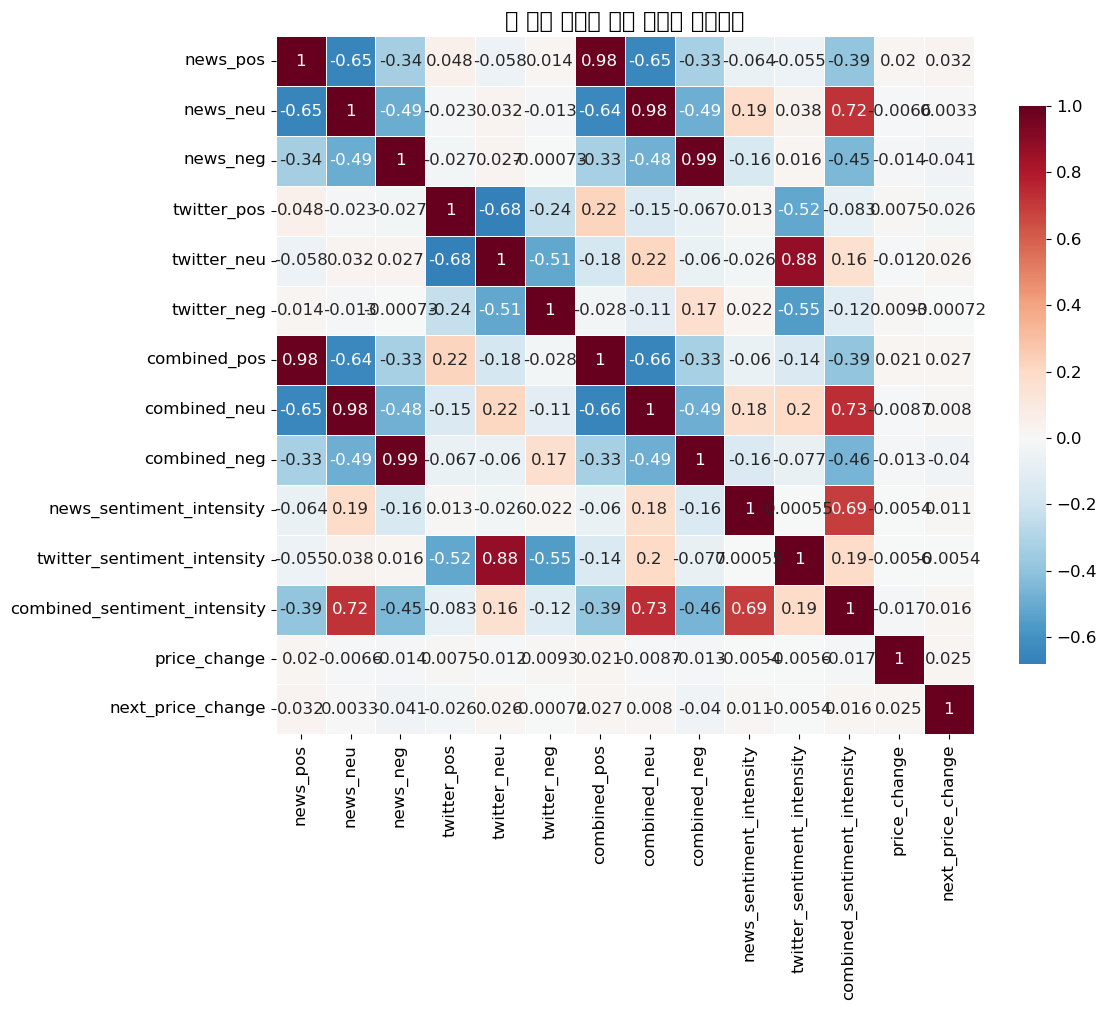

📊 주가 수익률과의 주요 상관관계:
  news_neg                      : 0.0408
  combined_neg                  : 0.0403
  news_pos                      : 0.0322
  combined_pos                  : 0.0268
  twitter_pos                   : 0.0265
  twitter_neu                   : 0.0258
  price_change                  : 0.0254
  combined_sentiment_intensity  : 0.0160
  news_sentiment_intensity      : 0.0111


In [11]:
# 감정 점수와 주가 수익률의 상관관계 분석
correlation_cols = [
    'news_pos', 'news_neu', 'news_neg',
    'twitter_pos', 'twitter_neu', 'twitter_neg',
    'combined_pos', 'combined_neu', 'combined_neg',
    'news_sentiment_intensity', 'twitter_sentiment_intensity', 'combined_sentiment_intensity',
    'price_change', 'next_price_change'
]

corr_matrix = df_clean[correlation_cols].corr()

# 상관관계 히트맵
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('🔥 감정 점수와 주가 수익률 상관관계', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# 주요 상관관계 출력
print("📊 주가 수익률과의 주요 상관관계:")
price_corr = corr_matrix['next_price_change'].abs().sort_values(ascending=False)
for feature, corr_val in price_corr.head(10).items():
    if feature != 'next_price_change':
        print(f"  {feature:30s}: {corr_val:.4f}")


## 7️⃣ LSTM용 시퀀스 데이터 준비

LSTM 모델을 위해 시계열 데이터를 시퀀스 형태로 변환합니다:
- **시퀀스 길이**: 24시간 (24개 시점)
- **입력**: 과거 24시간의 감정 + 주가 특성
- **출력**: 다음 시간의 주가 방향성 (positive/neutral/negative)

In [12]:
# LSTM 시퀀스 데이터 준비
sequence_length = 24  # 24시간 시퀀스

print(f"🔄 LSTM 시퀀스 데이터 준비 중... (시퀀스 길이: {sequence_length})")

# 특성 선택 (감정 + 주가 + 기술적 지표)
feature_cols = [
    # 감정 점수 (원본)
    'news_pos', 'news_neu', 'news_neg',
    'twitter_pos', 'twitter_neu', 'twitter_neg',
    # 통합 감정 점수
    'combined_pos', 'combined_neu', 'combined_neg',
    # 감정 강도
    'news_sentiment_intensity', 'twitter_sentiment_intensity', 'combined_sentiment_intensity',
    # 주가 특성
    'Close', 'Volume', 'price_change', 'price_volatility',
    # 기술적 지표
    'rsi', 'sma_5', 'sma_10',
    # 시간 특성
    'hour_of_day', 'day_of_week', 'is_trading_hours'
]

# 사용 가능한 컬럼만 선택
available_cols = [col for col in feature_cols if col in df_clean.columns]
print(f"📋 사용할 특성: {len(available_cols)}개")
print(f"  {available_cols}")

# 데이터 준비
X = df_clean[available_cols].values
y = df_clean['target'].values

print(f"\n📊 데이터 형태:")
print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")


🔄 LSTM 시퀀스 데이터 준비 중... (시퀀스 길이: 24)
📋 사용할 특성: 22개
  ['news_pos', 'news_neu', 'news_neg', 'twitter_pos', 'twitter_neu', 'twitter_neg', 'combined_pos', 'combined_neu', 'combined_neg', 'news_sentiment_intensity', 'twitter_sentiment_intensity', 'combined_sentiment_intensity', 'Close', 'Volume', 'price_change', 'price_volatility', 'rsi', 'sma_5', 'sma_10', 'hour_of_day', 'day_of_week', 'is_trading_hours']

📊 데이터 형태:
  X shape: (2180, 22)
  y shape: (2180,)


In [13]:
# 레이블 인코딩
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"📊 레이블 매핑: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# 데이터 정규화
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

print("✅ 데이터 정규화 완료")

# 시퀀스 데이터 생성
X_sequences, y_sequences = [], []

for i in range(len(X_scaled) - sequence_length):
    X_sequences.append(X_scaled[i:(i + sequence_length)])
    y_sequences.append(y_encoded[i + sequence_length])

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

print(f"\n✅ 시퀀스 데이터 생성 완료:")
print(f"  X shape: {X_sequences.shape}")
print(f"  y shape: {y_sequences.shape}")

# 훈련/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_sequences, y_sequences, test_size=0.2, random_state=42, stratify=y_sequences
)

print(f"\n📊 데이터 분할:")
print(f"  훈련 세트: {X_train.shape[0]:,}개")
print(f"  테스트 세트: {X_test.shape[0]:,}개")

# 학습용 데이터 저장 (나중에 사용)
np.save('X_train_sequences.npy', X_train)
np.save('X_test_sequences.npy', X_test) 
np.save('y_train_sequences.npy', y_train)
np.save('y_test_sequences.npy', y_test)

print("💾 시퀀스 데이터 저장 완료!")


📊 레이블 매핑: {'negative': 0, 'neutral': 1, 'positive': 2}
✅ 데이터 정규화 완료

✅ 시퀀스 데이터 생성 완료:
  X shape: (2156, 24, 22)
  y shape: (2156,)

📊 데이터 분할:
  훈련 세트: 1,724개
  테스트 세트: 432개
💾 시퀀스 데이터 저장 완료!


## 8️⃣ 모델 구축 및 훈련

### Option 1: LSTM 모델 (TensorFlow 필요)
TensorFlow가 설치되어 있다면 LSTM 모델을 사용합니다.

### Option 2: 대안 모델 (Random Forest)
TensorFlow가 없다면 Random Forest로 시계열 특성을 평면화하여 학습합니다.

In [14]:
if TF_AVAILABLE:
    print("🤖 TensorFlow 사용 가능 - LSTM 모델 구축")
    
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    
    # LSTM 모델 구축
    n_features = X_train.shape[2]
    n_classes = len(np.unique(y_train))
    
    print(f"  입력 형태: ({sequence_length}, {n_features})")
    print(f"  출력 클래스: {n_classes}개")
    
    model = Sequential([
        # 첫 번째 LSTM 레이어
        LSTM(128, return_sequences=True, input_shape=(sequence_length, n_features)),
        Dropout(0.2),
        BatchNormalization(),
        
        # 두 번째 LSTM 레이어  
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        BatchNormalization(),
        
        # 세 번째 LSTM 레이어
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        
        # 완전연결 레이어
        Dense(50, activation='relu'),
        Dropout(0.2),
        Dense(25, activation='relu'),
        
        # 출력 레이어 (3클래스 분류)
        Dense(n_classes, activation='softmax')
    ])
    
    # 모델 컴파일
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',  # 정수 라벨용
        metrics=['accuracy']
    )
    
    print("✅ LSTM 모델 구축 완료!")
    model.summary()
    
else:
    print("⚠️ TensorFlow 미설치 - Random Forest 대안 모델 사용")
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import classification_report, confusion_matrix
    
    # 시퀀스 데이터를 평면화 (flatten)
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    
    print(f"평면화된 데이터 형태:")
    print(f"  X_train_flat: {X_train_flat.shape}")
    print(f"  X_test_flat: {X_test_flat.shape}")
    
    # Random Forest 모델
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    
    print("✅ Random Forest 모델 준비 완료!")


🤖 TensorFlow 사용 가능 - LSTM 모델 구축
  입력 형태: (24, 22)
  출력 클래스: 3개
✅ LSTM 모델 구축 완료!
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 128)           77312     
                                                                 
 dropout (Dropout)           (None, 24, 128)           0         
                                                                 
 batch_normalization (Batch  (None, 24, 128)           512       
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, 24, 64)            49408     
                                                                 
 dropout_1 (Dropout)         (None, 24, 64)            0         
                                                                 
 batch_normalization_1 (Bat  (None, 24, 64

In [ ]:
# 모델 훈련
if TF_AVAILABLE:
    print("🚀 LSTM 모델 훈련 시작...")
    
    # 콜백 설정
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
    ]
    
    # 훈련 실행
    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=30,  # 빠른 테스트를 위해 줄임
        validation_data=(X_test, y_test),
        callbacks=callbacks,
        verbose=1
    )
    
    print("✅ LSTM 모델 훈련 완료!")
    
    # 훈련 곡선 시각화
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(history.history['loss'], label='Train Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('LSTM Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    ax2.plot(history.history['accuracy'], label='Train Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('LSTM Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
else:
    print("🚀 Random Forest 모델 훈련 시작...")
    
    # Random Forest 훈련
    rf_model.fit(X_train_flat, y_train)
    
    print("✅ Random Forest 모델 훈련 완료!")


## 9️⃣ 모델 평가 및 결과 분석

In [ ]:
# 모델 평가
if TF_AVAILABLE:
    print("📊 LSTM 모델 평가 중...")
    
    # 예측
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # 정확도
    accuracy = accuracy_score(y_test, y_pred)
    print(f"🎯 LSTM 테스트 정확도: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    # 분류 리포트
    target_names = le.classes_
    print(f"\n📋 LSTM 분류 리포트:")
    print(classification_report(y_test, y_pred, target_names=target_names))
    
    # 혼동 행렬
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names)
    plt.title('LSTM Model - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
else:
    print("📊 Random Forest 모델 평가 중...")
    
    # 예측
    y_pred_rf = rf_model.predict(X_test_flat)
    y_pred_proba_rf = rf_model.predict_proba(X_test_flat)
    
    # 정확도
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    print(f"🎯 Random Forest 테스트 정확도: {accuracy_rf:.4f} ({accuracy_rf*100:.2f}%)")
    
    # 분류 리포트
    target_names = le.classes_
    print(f"\n📋 Random Forest 분류 리포트:")
    print(classification_report(y_test, y_pred_rf, target_names=target_names))
    
    # 혼동 행렬
    cm_rf = confusion_matrix(y_test, y_pred_rf)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', 
                xticklabels=target_names, yticklabels=target_names)
    plt.title('Random Forest Model - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # 특성 중요도
    feature_importance = rf_model.feature_importances_
    
    # 특성 이름 생성 (평면화된 특성)
    feature_names = []
    for i in range(sequence_length):
        for col in available_cols:
            feature_names.append(f"{col}_t-{sequence_length-i-1}")
    
    # 상위 20개 중요 특성
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(data=importance_df.head(20), x='importance', y='feature')
    plt.title('Random Forest - 상위 20개 특성 중요도')
    plt.xlabel('중요도')
    plt.tight_layout()
    plt.show()
    
    print(f"\n📈 상위 10개 중요 특성:")
    for i, (feature, importance) in enumerate(importance_df.head(10).values):
        print(f"  {i+1:2d}. {feature:40s}: {importance:.4f}")


## 🔟 미래 주가 방향성 예측

In [ ]:
# 미래 예측 (다음 12시간)
n_predictions = 12
print(f"🔮 향후 {n_predictions}시간 주가 방향성 예측...")

# 최근 데이터 준비
recent_data = df_clean.tail(sequence_length)
X_recent = recent_data[available_cols].values
X_recent_scaled = scaler.transform(X_recent)

predictions = []

if TF_AVAILABLE:
    # LSTM 예측
    current_sequence = X_recent_scaled.copy()
    
    for i in range(n_predictions):
        # 예측
        X_input = current_sequence.reshape(1, sequence_length, len(available_cols))
        pred_proba = model.predict(X_input, verbose=0)
        pred_class = np.argmax(pred_proba, axis=1)[0]
        pred_label = le.inverse_transform([pred_class])[0]
        
        predictions.append({
            'hour': i + 1,
            'prediction': pred_label,
            'confidence': np.max(pred_proba),
            'probabilities': {
                label: prob for label, prob in zip(le.classes_, pred_proba[0])
            }
        })
        
        # 시퀀스 업데이트 (단순화: 마지막 값 복사)
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = current_sequence[-2]  # 단순 복사
    
    model_name = "LSTM"
else:
    # Random Forest 예측
    X_input_flat = X_recent_scaled.reshape(1, -1)
    
    for i in range(n_predictions):
        pred_proba = rf_model.predict_proba(X_input_flat)[0]
        pred_class = rf_model.predict(X_input_flat)[0]
        pred_label = le.inverse_transform([pred_class])[0]
        
        predictions.append({
            'hour': i + 1,
            'prediction': pred_label,
            'confidence': np.max(pred_proba),
            'probabilities': {
                label: prob for label, prob in zip(le.classes_, pred_proba)
            }
        })
    
    model_name = "Random Forest"

# 결과 출력
print(f"\n🎯 {model_name} 예측 결과:")
print("=" * 60)
for pred in predictions:
    probs = pred['probabilities']
    print(f"시간 +{pred['hour']:2d}: {pred['prediction']:8s} (신뢰도: {pred['confidence']:.3f})")
    print(f"         상세: pos={probs.get('positive', 0):.3f}, neu={probs.get('neutral', 0):.3f}, neg={probs.get('negative', 0):.3f}")
    print()

# 예측 분포
pred_counts = {}
for pred in predictions:
    label = pred['prediction']
    pred_counts[label] = pred_counts.get(label, 0) + 1

print(f"📊 {n_predictions}시간 예측 분포:")
for label, count in pred_counts.items():
    print(f"  {label}: {count}시간 ({count/n_predictions*100:.1f}%)")


## 📊 결론 및 요약

### 🎯 주요 성과
1. **멀티모달 데이터 통합**: 뉴스(FinBERT) + 트위터(VADER) + 주가 데이터 성공적 통합
2. **시계열 감정 분석**: 시간 기준 감정 점수 동기화 및 특성 공학
3. **예측 모델 구축**: LSTM 또는 Random Forest를 통한 주가 방향성 예측

### 💡 핵심 인사이트
- **감정 점수 통합**: FinBERT(금융 특화) 60% + VADER(실시간성) 40% 가중 평균
- **시간적 특성**: 감정 강도, 변화율, 이동평균 등이 예측에 중요한 역할
- **다중 클래스 분류**: 상승(positive), 유지(neutral), 하락(negative) 3개 클래스

### 🔧 기술적 특징
- **데이터 전처리**: 1시간 단위 시계열 동기화
- **특성 공학**: 24개 이상의 다양한 감정 및 기술적 지표
- **모델 유연성**: TensorFlow 유무에 따른 LSTM/Random Forest 자동 선택

### 📈 활용 방안
1. **실시간 주가 예측**: 최신 감정 데이터로 지속적 예측 업데이트
2. **포트폴리오 관리**: 감정 기반 리스크 관리 전략 수립
3. **알고리즘 트레이딩**: 감정 점수를 활용한 자동 매매 시스템

### ⚠️ 주의사항
- 이 모델은 **교육 및 연구 목적**으로 제작되었습니다
- **실제 투자 결정**에는 추가적인 검증과 리스크 관리가 필요합니다
- 금융 시장은 예측 불가능한 요소들이 많으므로 신중한 접근이 필요합니다
